In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# -----------------------------
# 1. Load Real & Synthetic Data
# -----------------------------
real_data = pd.read_csv("Preprocessed_Dataset.csv")
synthetic_data = pd.read_csv("TTS-1.csv")

# Drop non-numeric columns if any (e.g., timestamps)
real_data = real_data.select_dtypes(include=[np.number])
synthetic_data = synthetic_data.select_dtypes(include=[np.number])

In [3]:
# -----------------------------
# 2. Standardize the Data
# -----------------------------
scaler = StandardScaler()
real_scaled = scaler.fit_transform(real_data)
synthetic_scaled = scaler.transform(synthetic_data)

In [4]:
# -----------------------------
# 3. PCA Embedding
# -----------------------------
pca_components = 17  # You can adjust based on dataset size
pca = PCA(n_components=pca_components)

# Fit PCA on real data
real_emb = pca.fit_transform(real_scaled)
synthetic_emb = pca.transform(synthetic_scaled)

In [5]:
# -----------------------------
# 4. Compute Means & Covariances
# -----------------------------
mu_real = np.mean(real_emb, axis=0)
sigma_real = np.cov(real_emb, rowvar=False)

mu_synth = np.mean(synthetic_emb, axis=0)
sigma_synth = np.cov(synthetic_emb, rowvar=False)

In [6]:
# -----------------------------
# 5. Compute Frechet Transformer Distance (FTD)
# -----------------------------
diff = mu_real - mu_synth
covmean = sqrtm(sigma_real.dot(sigma_synth))

# Handle potential imaginary values from sqrtm
if np.iscomplexobj(covmean):
    covmean = covmean.real

ftd = np.sum(diff**2) + np.trace(sigma_real + sigma_synth - 2 * covmean)
print(f"Frechet Transformer Distance (FTD): {ftd:.4f}")

Frechet Transformer Distance (FTD): 5.6557


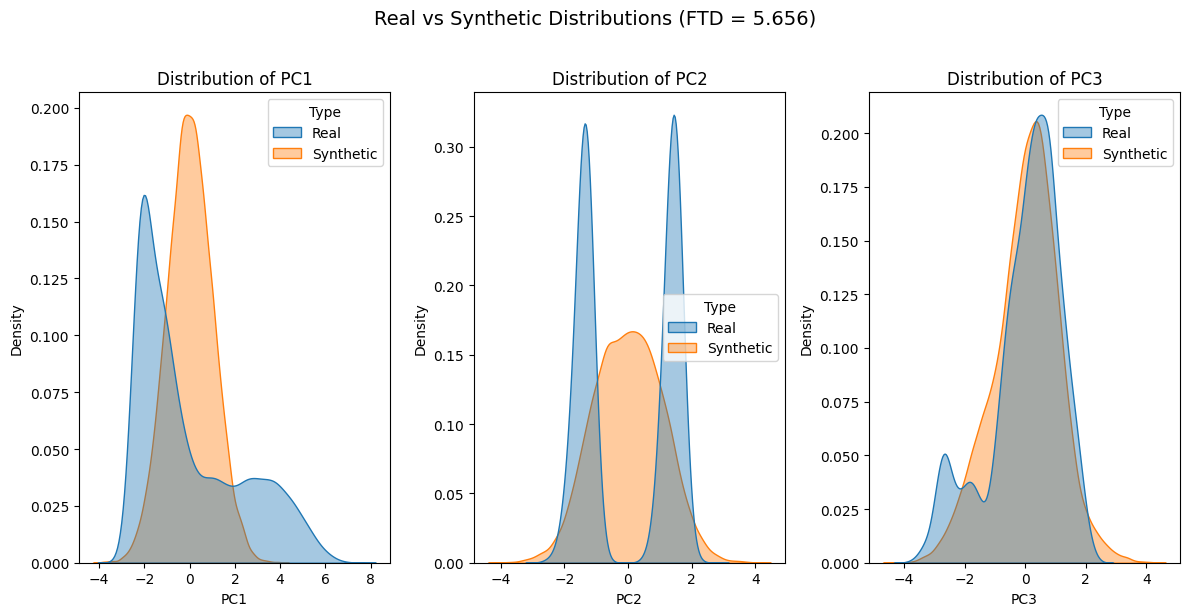

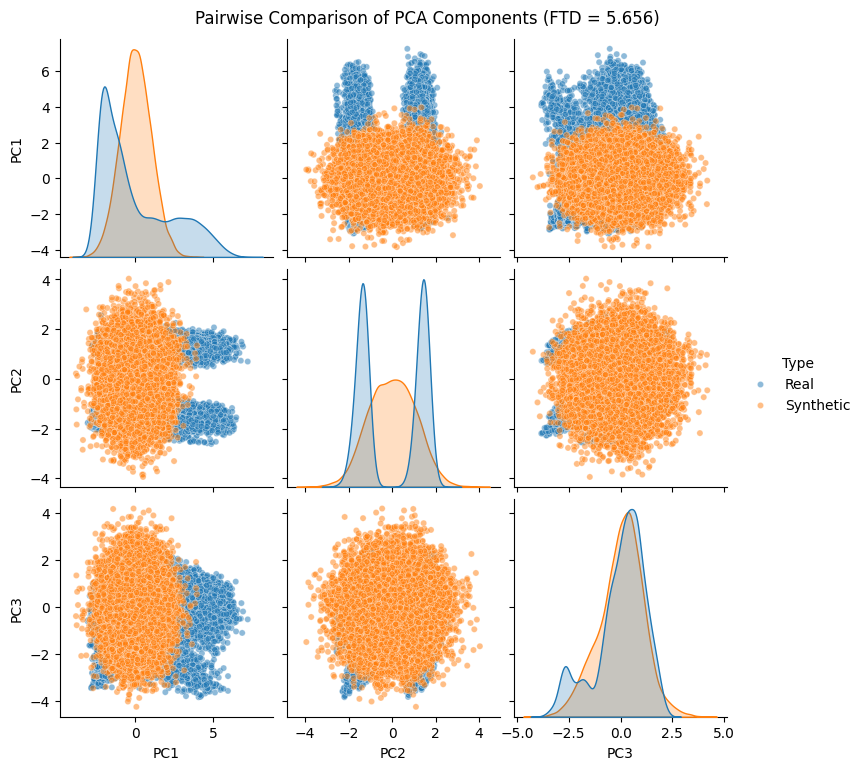

C:\Users\HP\AppData\Local\Temp\ipykernel_5388\1428858035.py:38: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=components, y=explained_variance, palette='coolwarm')


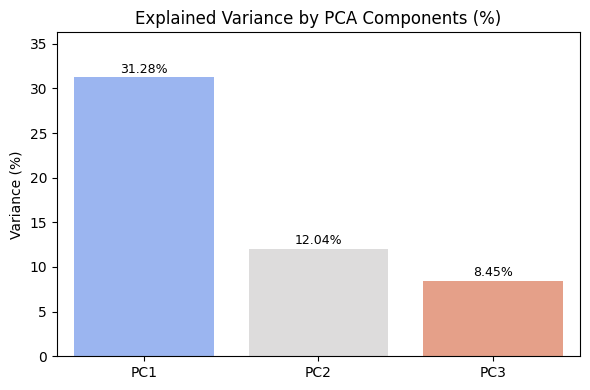

In [9]:
# -----------------------------
# 5. Visualization with FTD and PCA Variance
# -----------------------------

# Convert embeddings to DataFrame for plotting
real_df = pd.DataFrame(real_emb[:, :3], columns=['PC1', 'PC2', 'PC3'])
synthetic_df = pd.DataFrame(synthetic_emb[:, :3], columns=['PC1', 'PC2', 'PC3'])
real_df['Type'] = 'Real'
synthetic_df['Type'] = 'Synthetic'
combined_df = pd.concat([real_df, synthetic_df])

# =====================
# KDE Plot for PC1, PC2, PC3
# =====================
plt.figure(figsize=(12, 6))
plt.suptitle(f'Real vs Synthetic Distributions (FTD = {ftd:.3f})', fontsize=14, y=1.02)
for i, comp in enumerate(['PC1', 'PC2', 'PC3']):
    plt.subplot(1, 3, i + 1)
    sns.kdeplot(data=combined_df, x=comp, hue="Type", fill=True, alpha=0.4)
    plt.title(f'Distribution of {comp}')
plt.tight_layout()
plt.show()

# =====================
# Pairplot for top 3 PCA components
# =====================
pairplot_fig = sns.pairplot(combined_df, vars=['PC1', 'PC2', 'PC3'], hue='Type', diag_kind='kde', plot_kws={'alpha':0.5, 's':20})
pairplot_fig.fig.suptitle(f'Pairwise Comparison of PCA Components (FTD = {ftd:.3f})', y=1.02)
plt.show()

# =====================
# Bar Plot: Explained Variance Comparison
# =====================
explained_variance = pca.explained_variance_ratio_[:3] * 100  # Top 3 components
components = ['PC1', 'PC2', 'PC3']

plt.figure(figsize=(6, 4))
sns.barplot(x=components, y=explained_variance, palette='coolwarm')
plt.title('Explained Variance by PCA Components (%)')
plt.ylabel('Variance (%)')
plt.ylim(0, max(explained_variance) + 5)
for i, v in enumerate(explained_variance):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha='center', fontsize=9)
plt.tight_layout()
plt.show()
